### Loading Libraries

In [1]:
# load libararies
library(vegan)
library(phyloseq)
library(ranacapa)
library(ape)
library(ggplot2)
library(ggpubr)
library(reshape2)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘ggpubr’


The following object is masked from ‘package:ape’:

    rotate




In [2]:
# create directories to save files
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'figure2'), showWarnings = FALSE)

# PCoA: Bray Curtis + Permanova

### Loading data

In [3]:
# load genus level agglomerated data
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')

# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))

# tax_data['names'] <- paste(tax_data[, 'Family'], tax_data[, 'Genus'], sep=';')
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]

# find ids of people who were dewormed
onlydewormed_ids <- sample_data(ps)[sample_data(ps)[['collection_timepoint']] == 'follow-up',]$host_subject_id
# select only samples from subjects participated in the follow-up study
ps <- subset_samples(ps, host_subject_id %in% onlydewormed_ids)
length(onlydewormed_ids)*2 == nsamples(ps)

[1] TRUE

In [4]:
# Compute covariation microbial genera with PCoA axis
# (The code is adjusted from biplot function of ape library)
# Credit source: https://github.com/cran/ape/blob/master/R/biplot.pcoa.R

compute_loadings <- function(x, Y) {
    plot.axes=c(1,2)
    pr.coo <- x$vectors
    n <- nrow(Y)
    points.stand <- scale(pr.coo[,plot.axes])
    S <- cov(Y, points.stand)
    U <- S %*% diag((x$values$Eigenvalues[plot.axes]/(n-1))^(-0.5))
    colnames(U) <- c('PC1', 'PC2')
    U <- data.frame(U)
    U['Length'] <- sqrt(U[['PC1']]**2+U[['PC2']]**2)
    U <- U[order(-U[['Length']]), ]
    U['direction'] <- (U['PC1']/abs(U['PC1'])+1)/2+(U['PC2']/abs(U['PC2'])+3)
    return(U)
}

### 1. PCoA with Bray-Curtis Distances

In [5]:
# normalize counts
ps_relative <- transform_sample_counts(ps, function(x){x / sum(x)})
ps_relative

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 397 taxa and 134 samples ]
sample_data() Sample Data:       [ 134 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 397 taxa by 7 taxonomic ranks ]

In [6]:
otu_data <- data.frame(otu_table(ps_relative))
# compute bray-curtis pairwise distances
bray_curtis_dist <- vegdist(otu_data, method = "bray")
# compute pcoa
pcoa_res <- pcoa(bray_curtis_dist)

# reformat the result table for plotting with ggplot
pcoa_coordinates <- data.frame(pcoa_res$vectors)[, c('Axis.1', 'Axis.2')]
colnames(pcoa_coordinates) <- c('PC1', 'PC2')
pcoa_coordinates <- cbind(pcoa_coordinates, sample_data(ps)[, 'collection_timepoint'])
pcoa_coordinates$collection_timepoint <- factor(pcoa_coordinates$collection_timepoint, levels=c('baseline', 'follow-up'))
levels(pcoa_coordinates$collection_timepoint) <- c("Before deworming", "1-year follow-up")

In [7]:
# compute biplot (project microbial genera on new axis)
loadings <- compute_loadings(pcoa_res, otu_data)
# choose top 5 loadings with largest covariance for first 2 PC axis
loadings_selected <- loadings[1:5, ]
loadings_selected['names'] <- rownames(loadings_selected)
# select 1 laoding per each plot quadrant
loadings_selected <- loadings_selected[row.names(unique(loadings_selected['direction'])), ]

In [8]:
# permanova test
set.seed(234) # set see for reproducibility
permanova_braycurtis <- adonis2(as.formula(paste0("bray_curtis_dist ~  ", 'collection_timepoint')), 
                    data=data.frame(sample_data(ps)), permutations=9999)
permanova_braycurtis

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
collection_timepoint,1,0.3886913,0.02271056,3.067458,0.0064
Residual,132,16.7263097,0.97728944,NA,NA
Total,133,17.1150010,1.00000000,NA,NA


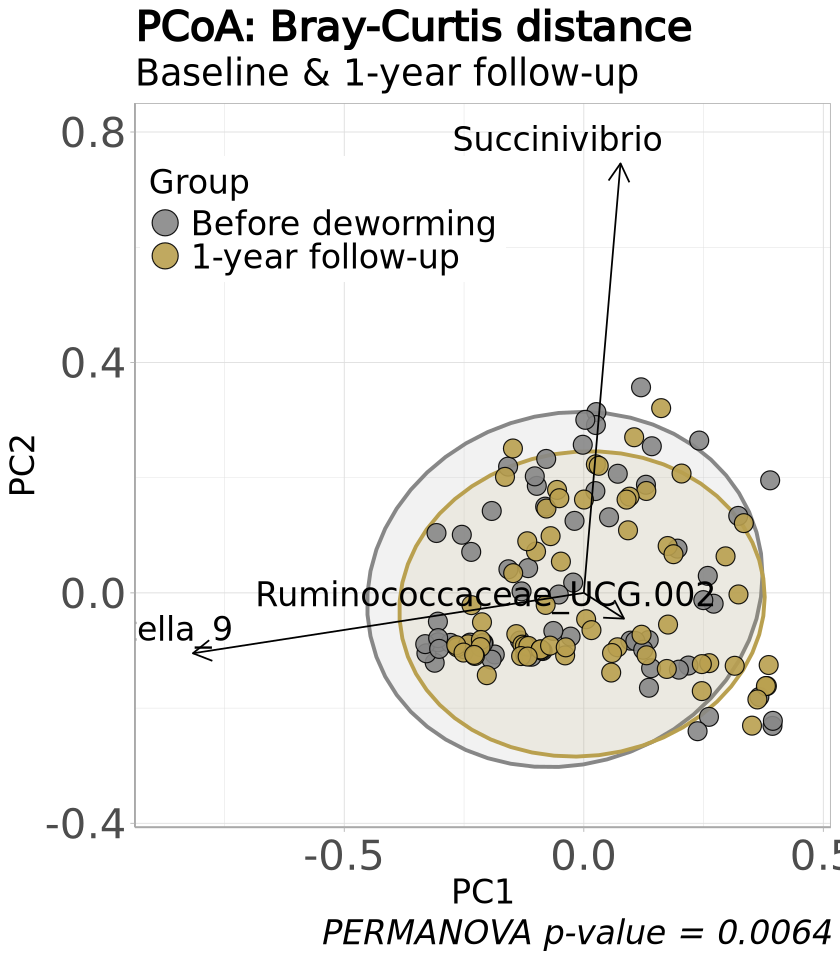

In [9]:
width = 7
height = 8
options(repr.plot.width=width, repr.plot.height=height)

comparisons <- list(c("baseline", "follow-up"))

p_braycurtis <- ggplot() +
# plot group circles
      stat_ellipse(data = pcoa_coordinates, geom = "polygon",
                   aes(x=PC1, y=PC2, color = collection_timepoint, 
                       fill = after_scale(alpha(colour, 0.1))), lwd=1.1, level=0.9, show.legend = FALSE) +
# plot sample values projected on PCoA
      geom_point(data = pcoa_coordinates, aes(x=PC1, y=PC2, fill = collection_timepoint), 
                 size = 5, alpha=0.9, pch=21, ) +
# plot projected microbial genera
      geom_segment(data = loadings_selected, 
                   aes(x = 0, y = 0, xend = PC1, yend = PC2), 
                   arrow = arrow(length = unit(0.03, "npc")), alpha = 1) + 
# plot names of the projected genera
      geom_text(data = loadings_selected, 
                mapping = aes(x = PC1, y = PC2, label = names), 
                hjust = 0.8, vjust = -0.5, colour = "black", size = 7) +
# change default colors
      scale_fill_manual('Group', values = c('#878787', '#b9a04f')) +
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
# expand x and y limits to make plot better looking
      scale_x_continuous(expand = expansion(mult = 0.1)) +
      scale_y_continuous(expand = expansion(mult = 0.1)) +
# add titles
      labs(title = "PCoA: Bray-Curtis distance", 
           subtitle = "Baseline & 1-year follow-up", 
           caption = paste0("PERMANOVA p-value = ", permanova_braycurtis['collection_timepoint', 'Pr(>F)'])) +
# custom plot design
      theme_light() +
      theme(axis.text=element_text(size=25),
            axis.title=element_text(size=20), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            plot.caption = element_text(face = "italic"),
            axis.text.x.bottom = element_text(size=25, angle=0, face='plain', hjust=0.5, vjust=0.5),
            text = element_text(size = 25), 
            legend.title=element_text(size=20),
            axis.line = element_line(color = "darkgrey", linewidth = 0.5), 
            legend.position = "inside",
            legend.position.inside = c(0.27, 0.84))  +
       guides(fill = guide_legend(override.aes = list(size=7)))

# ensure the order of groups in the legend
p_braycurtis$data$collection_timepoint <- as.character(p_braycurtis$data$collection_timepoint)
p_braycurtis$data$collection_timepoint <- factor(p_braycurtis$data$collection_timepoint, levels=unlist(comparisons))

k <- 0.45
ggsave(file=file.path('../../results/figures', 'figure2', 'before_after.pcoa.svg'), plot=p_braycurtis, 
       width=width*k, height=height*k, scaling = k)
p_braycurtis